# Data loading

In [1]:
import itertools
import random
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

from ev_simulation_model.data import load_norway_residential_data
from ev_simulation_model.io import ConditionalMvnMixtureExporter
from ev_simulation_model.models import ConditionalMvnMixture, MultivariateNormal

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 100
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
CWD = Path("/Users/phipag/Git/powertac/ev-simulation-model")

In [3]:
raw_df = load_norway_residential_data(CWD / "data" / "norway_residential" / "Dataset 1_EV charging reports.csv")

# Density estimation

## Exploring the densities

In [4]:
density_df = raw_df[["Duration_hours", "El_kWh", "Start_plugin_hour"]]
density_df

Duration_hours  El_kWh  Start_plugin_hour
0           0.050000    0.30                 10
1           0.136667    0.87                 10
2           8.216389   29.87                 11
3          24.419722   15.56                 16
4           0.970556    3.62                 22
...              ...     ...                ...
6873        4.530000   13.43                 17
6874        3.182222    9.10                 18
6875        1.203889    4.28                 19
6876        0.352500    2.31                 19
6877        3.184167   20.14                 20

[6878 rows x 3 columns]

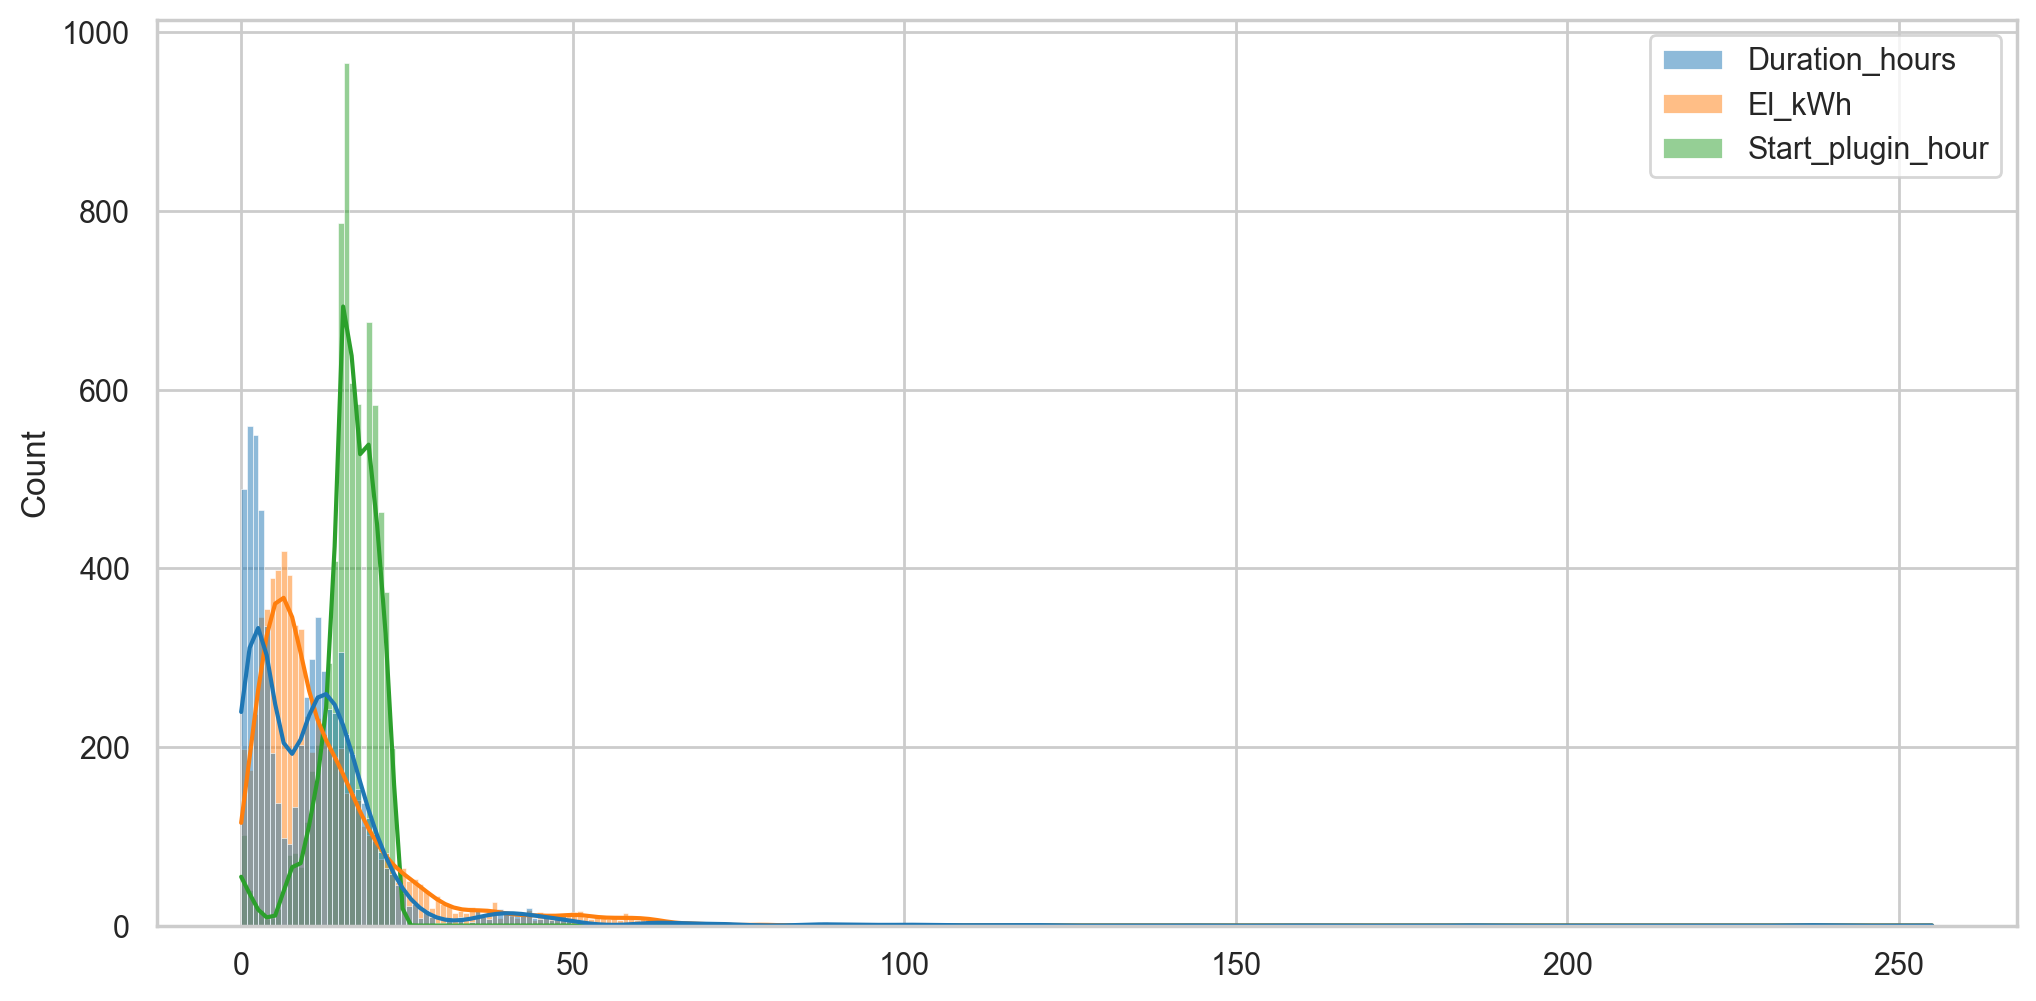

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(density_df, kde=True, ax=ax);

Let's remove the outliers in `Duration_hours` and `El_kWh` first by filtering out datapoints with a `zscore < 3`.

In [6]:
density_df = density_df[
    (density_df["Duration_hours"] - density_df["Duration_hours"].mean()) / density_df["Duration_hours"].std(ddof=0) < 3
].copy()
density_df = density_df[
    (density_df["El_kWh"] - density_df["El_kWh"].mean()) / density_df["El_kWh"].std(ddof=0) < 3
].copy()
density_df

Duration_hours  El_kWh  Start_plugin_hour
0           0.050000    0.30                 10
1           0.136667    0.87                 10
2           8.216389   29.87                 11
3          24.419722   15.56                 16
4           0.970556    3.62                 22
...              ...     ...                ...
6873        4.530000   13.43                 17
6874        3.182222    9.10                 18
6875        1.203889    4.28                 19
6876        0.352500    2.31                 19
6877        3.184167   20.14                 20

[6544 rows x 3 columns]

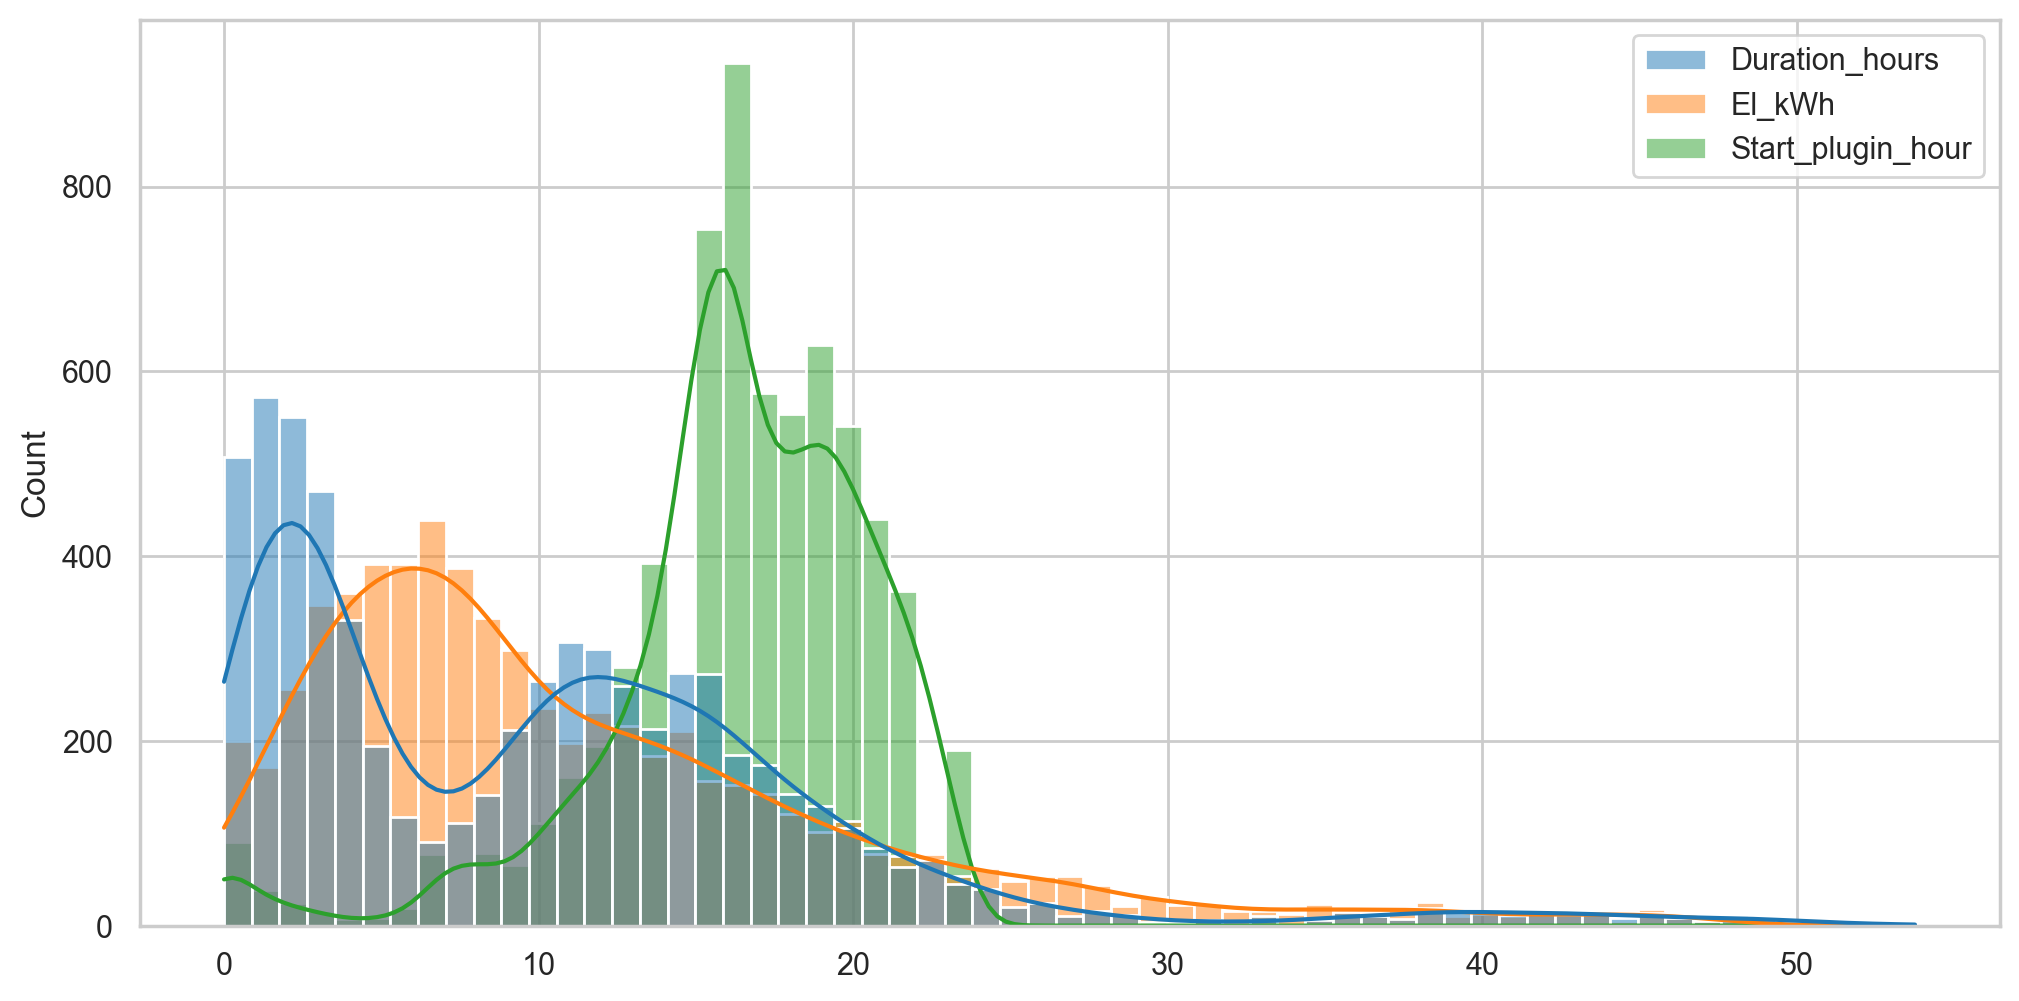

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(density_df, kde=True, ax=ax);

In [8]:
density_df.describe()

Duration_hours       El_kWh  Start_plugin_hour
count     6544.000000  6544.000000        6544.000000
mean        10.222456    11.363588          16.317848
std          9.062916     8.894950           4.345939
min          0.003333     0.010000           0.000000
25%          2.655625     5.100000          15.000000
50%          9.581806     8.800000          17.000000
75%         14.958056    15.290000          19.000000
max         53.754722    48.120000          23.000000

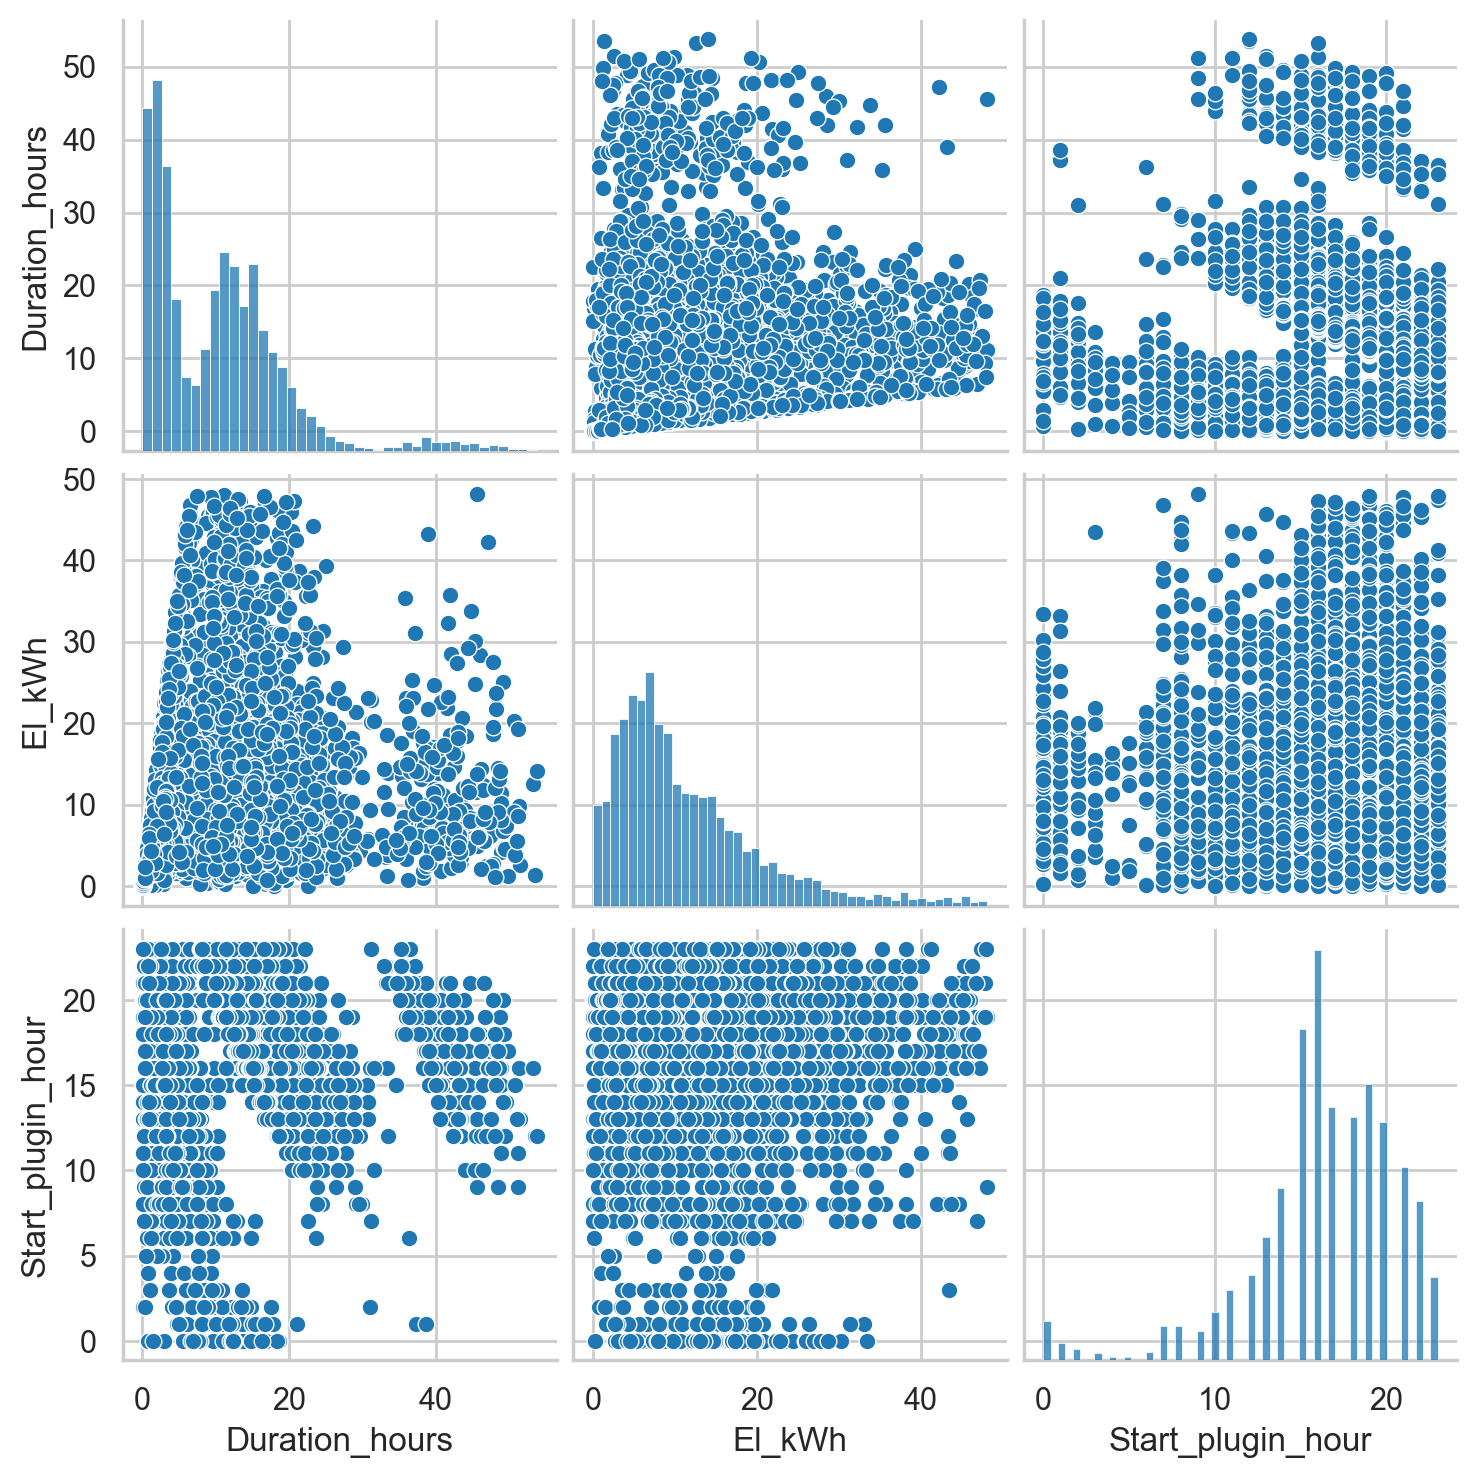

In [9]:
sns.pairplot(data=density_df, diag_kind="hist");

## Estimating the densities with a Gaussian Mixture Model

In [10]:
density_gmm_df = density_df.copy()

In [11]:
lowest_bic = np.infty
bics = []
n_components_range = range(1, 20)
cov_types = ["spherical", "tied", "diag", "full"]
for cov_type in cov_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=0)
        gmm.fit(density_gmm_df)
        bics.append(gmm.bic(density_gmm_df))
        if bics[-1] < lowest_bic:
            lowest_bic = bics[-1]
# Deleting last gmm variable to avoid confusion
del gmm

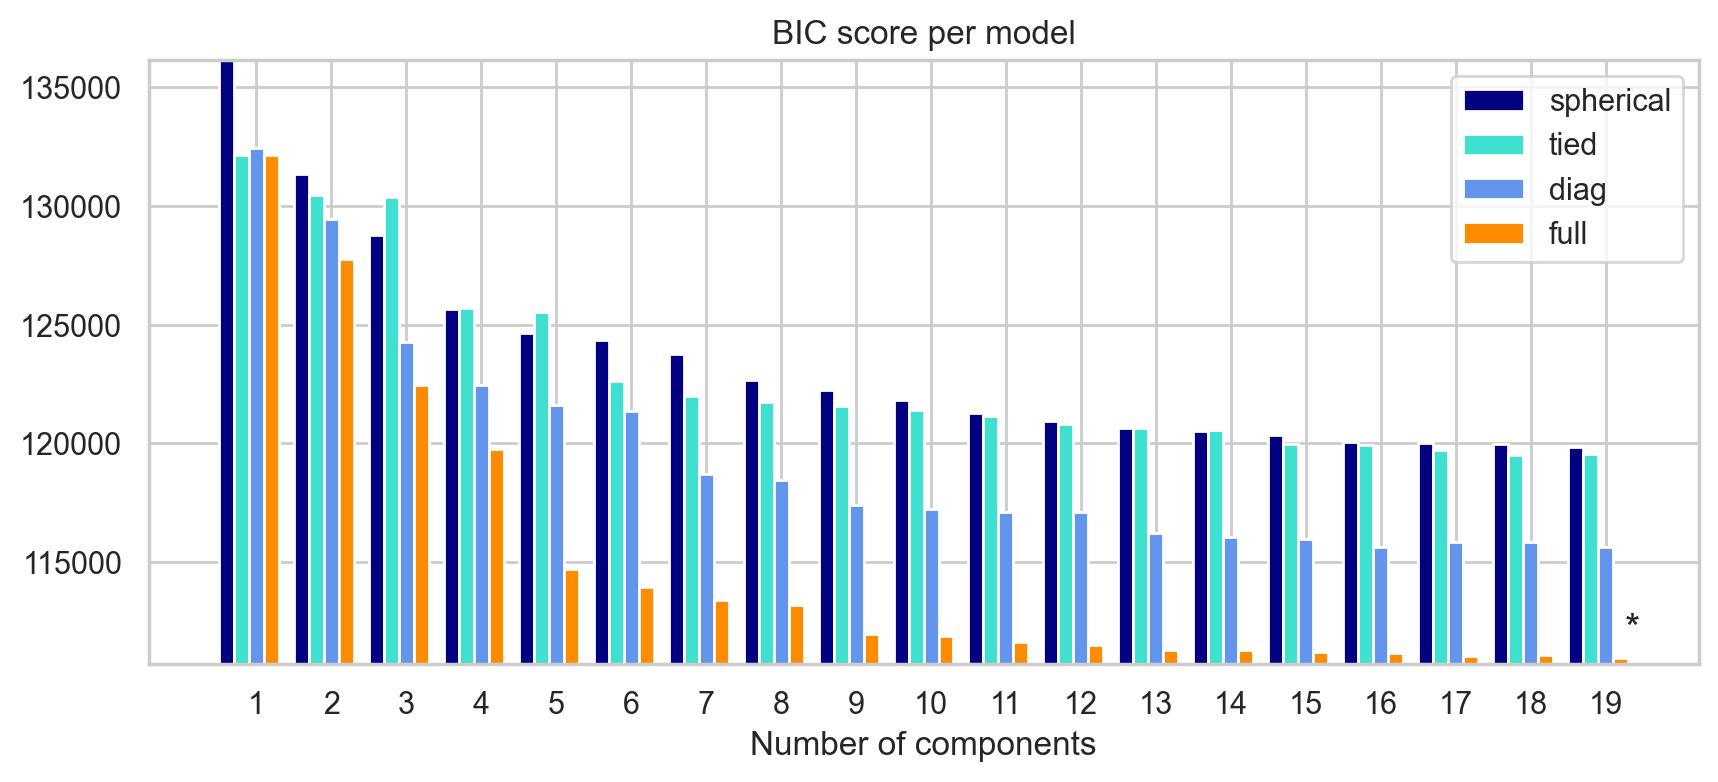

In [12]:
bics = np.array(bics)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
bars = []

plt.figure(figsize=(10, 4))
spl = plt.subplot(1, 1, 1)
for i, (cov_type, color) in enumerate(zip(cov_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bics[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bics.min() * 1.01 - 0.01 * bics.max(), bics.max()])
plt.title("BIC score per model")
xpos = np.mod(bics.argmin(), len(n_components_range)) + 0.65 + 0.2 * np.floor(bics.argmin() / len(n_components_range))
plt.text(xpos, bics.min() * 0.97 + 0.03 * bics.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cov_types)

In [13]:
best_gmm = GaussianMixture(n_components=5, covariance_type="full", random_state=0)
density_gmm_df["cluster"] = best_gmm.fit_predict(density_df)

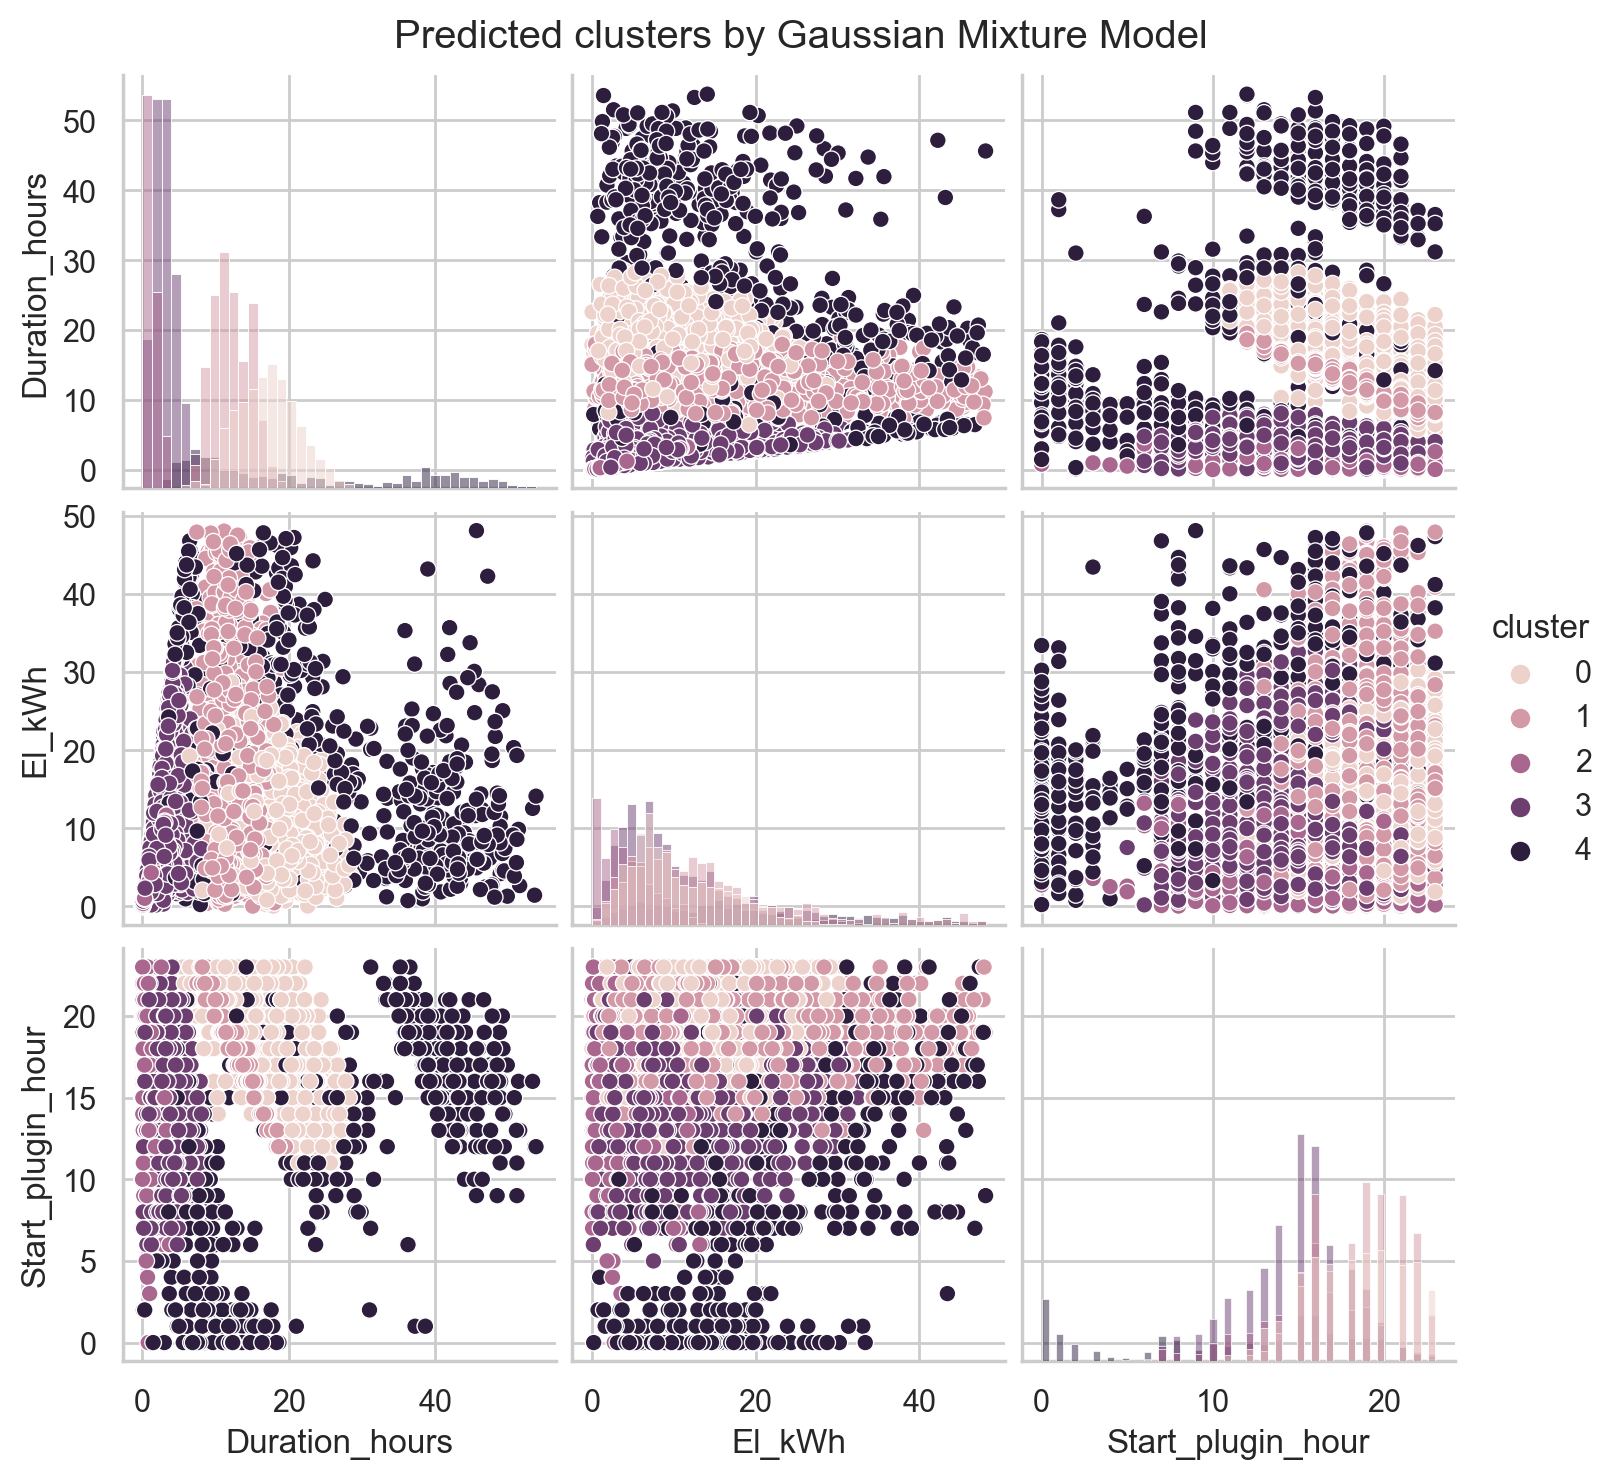

In [14]:
grid = sns.pairplot(data=density_gmm_df, hue="cluster", diag_kind="hist")
grid.figure.suptitle("Predicted clusters by Gaussian Mixture Model")
grid.tight_layout();

## Generating data from the fitted mixture distributions
This is the joint mixture distribution $p(\text{Duration_hours}, \text{El_kWh}, \text{Start_plugin_hour})$

In [15]:
samples, clusters = best_gmm.sample(len(density_df))
density_generated_df = pd.DataFrame(samples, columns=density_df.columns)
density_generated_df["cluster"] = clusters

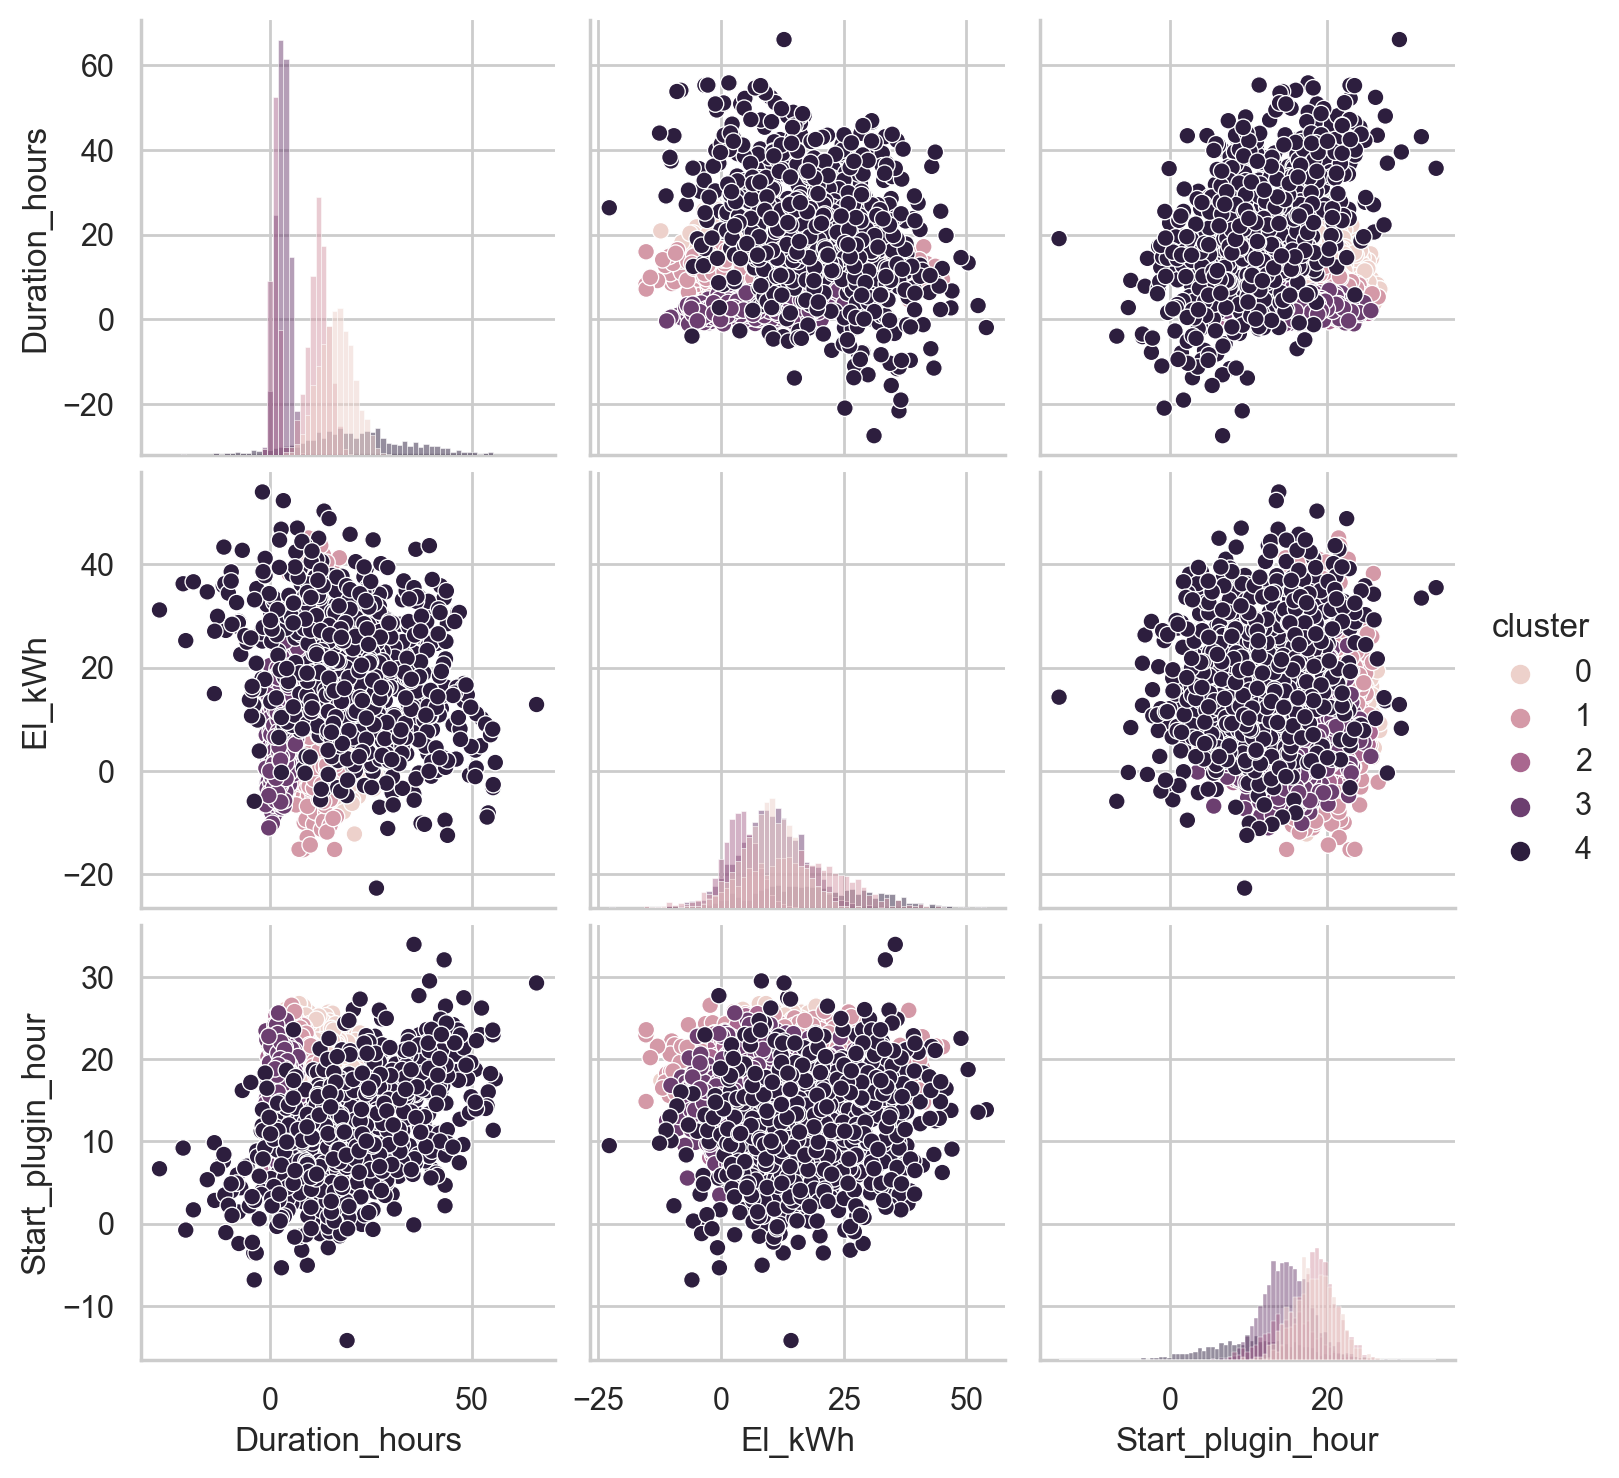

In [16]:
sns.pairplot(data=density_generated_df, hue="cluster", diag_kind="hist");

In [17]:
best_gmm.means_

array([[16.27807559, 10.31377236, 18.43250934],
       [12.18176491, 14.77768893, 18.80089312],
       [ 1.15435747,  4.12474982, 15.55221238],
       [ 3.07565393, 10.02363117, 14.90291084],
       [21.4811639 , 18.73971581, 11.54061503]])

In [18]:
best_gmm.covariances_

array([[[ 1.87081887e+01, -4.15188229e+00, -8.20127096e+00],
        [-4.15188229e+00,  3.38159314e+01,  3.73923506e+00],
        [-8.20127096e+00,  3.73923506e+00,  8.18433728e+00]],

       [[ 6.36278929e+00,  5.80137105e-01, -5.99239467e+00],
        [ 5.80137105e-01,  1.03502991e+02, -3.50890884e-01],
        [-5.99239467e+00, -3.50890884e-01,  6.03992805e+00]],

       [[ 7.77495585e-01,  2.80003561e+00, -4.49958574e-02],
        [ 2.80003561e+00,  1.00921998e+01, -1.52154721e-01],
        [-4.49958574e-02, -1.52154721e-01,  1.14469990e+01]],

       [[ 2.41230621e+00,  3.97291476e+00, -6.87083119e-01],
        [ 3.97291476e+00,  4.50052965e+01,  1.25861745e+00],
        [-6.87083119e-01,  1.25861745e+00,  9.13979493e+00]],

       [[ 2.11243085e+02, -6.19700421e+01,  5.15416293e+01],
        [-6.19700421e+01,  1.43581785e+02,  1.77586092e+01],
        [ 5.15416293e+01,  1.77586092e+01,  4.75771899e+01]]])

In [19]:
best_gmm.weights_

array([0.24367744, 0.2214327 , 0.13820255, 0.27830932, 0.11837799])

## Compare generated data with sample data

In [20]:
density_gen_vs_sample_df = pd.concat(
    [
        density_generated_df[["Duration_hours", "El_kWh", "Start_plugin_hour"]],
        density_df[["Duration_hours", "El_kWh", "Start_plugin_hour"]],
    ],
    axis=1,
)
density_gen_vs_sample_df.columns = [
    "Duration hours (generated)",
    "Electricity demand (generated)",
    "Hour of day (generated)",
    "Duration hours (true sample)",
    "Electricity demand (true sample)",
    "Hour of day (true sample)",
]

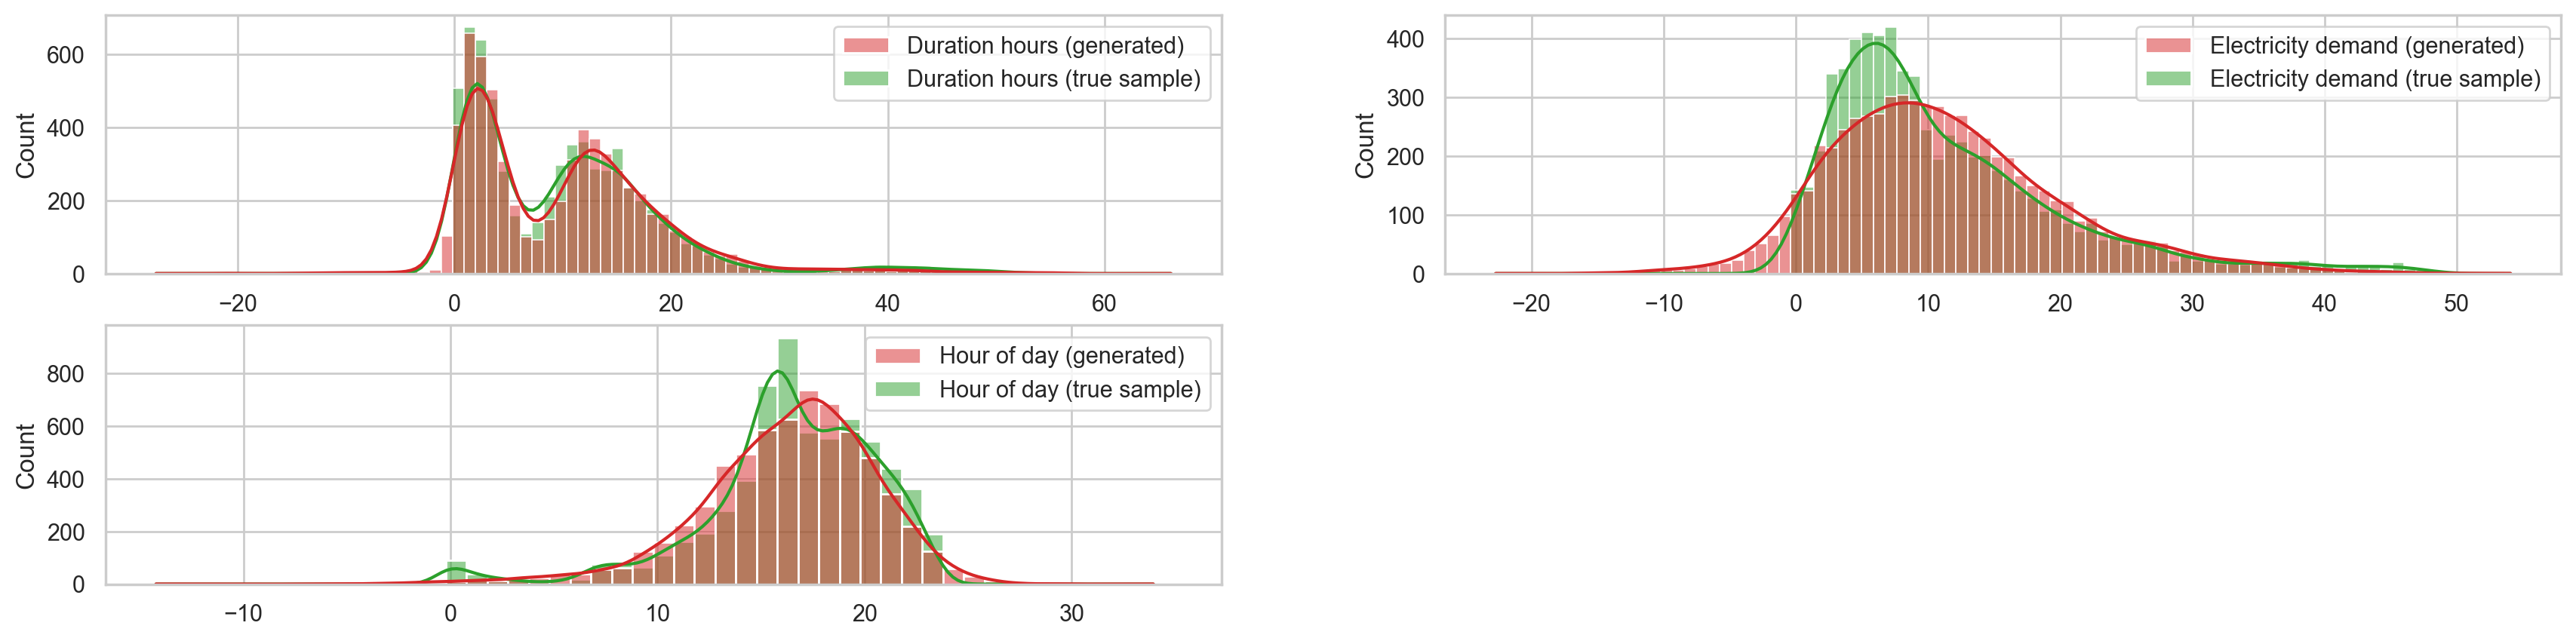

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(21, 5))
sns.histplot(
    density_gen_vs_sample_df[["Duration hours (generated)", "Duration hours (true sample)"]],
    kde=True,
    palette=["#d62728", "#2ca02c"],
    ax=ax1[0],
)
sns.histplot(
    density_gen_vs_sample_df[["Electricity demand (generated)", "Electricity demand (true sample)"]],
    kde=True,
    palette=["#d62728", "#2ca02c"],
    ax=ax1[1],
)
sns.histplot(
    density_gen_vs_sample_df[["Hour of day (generated)", "Hour of day (true sample)"]],
    kde=True,
    binwidth=1,
    palette=["#d62728", "#2ca02c"],
    ax=ax2[0],
)
fig.delaxes(ax2[1]);

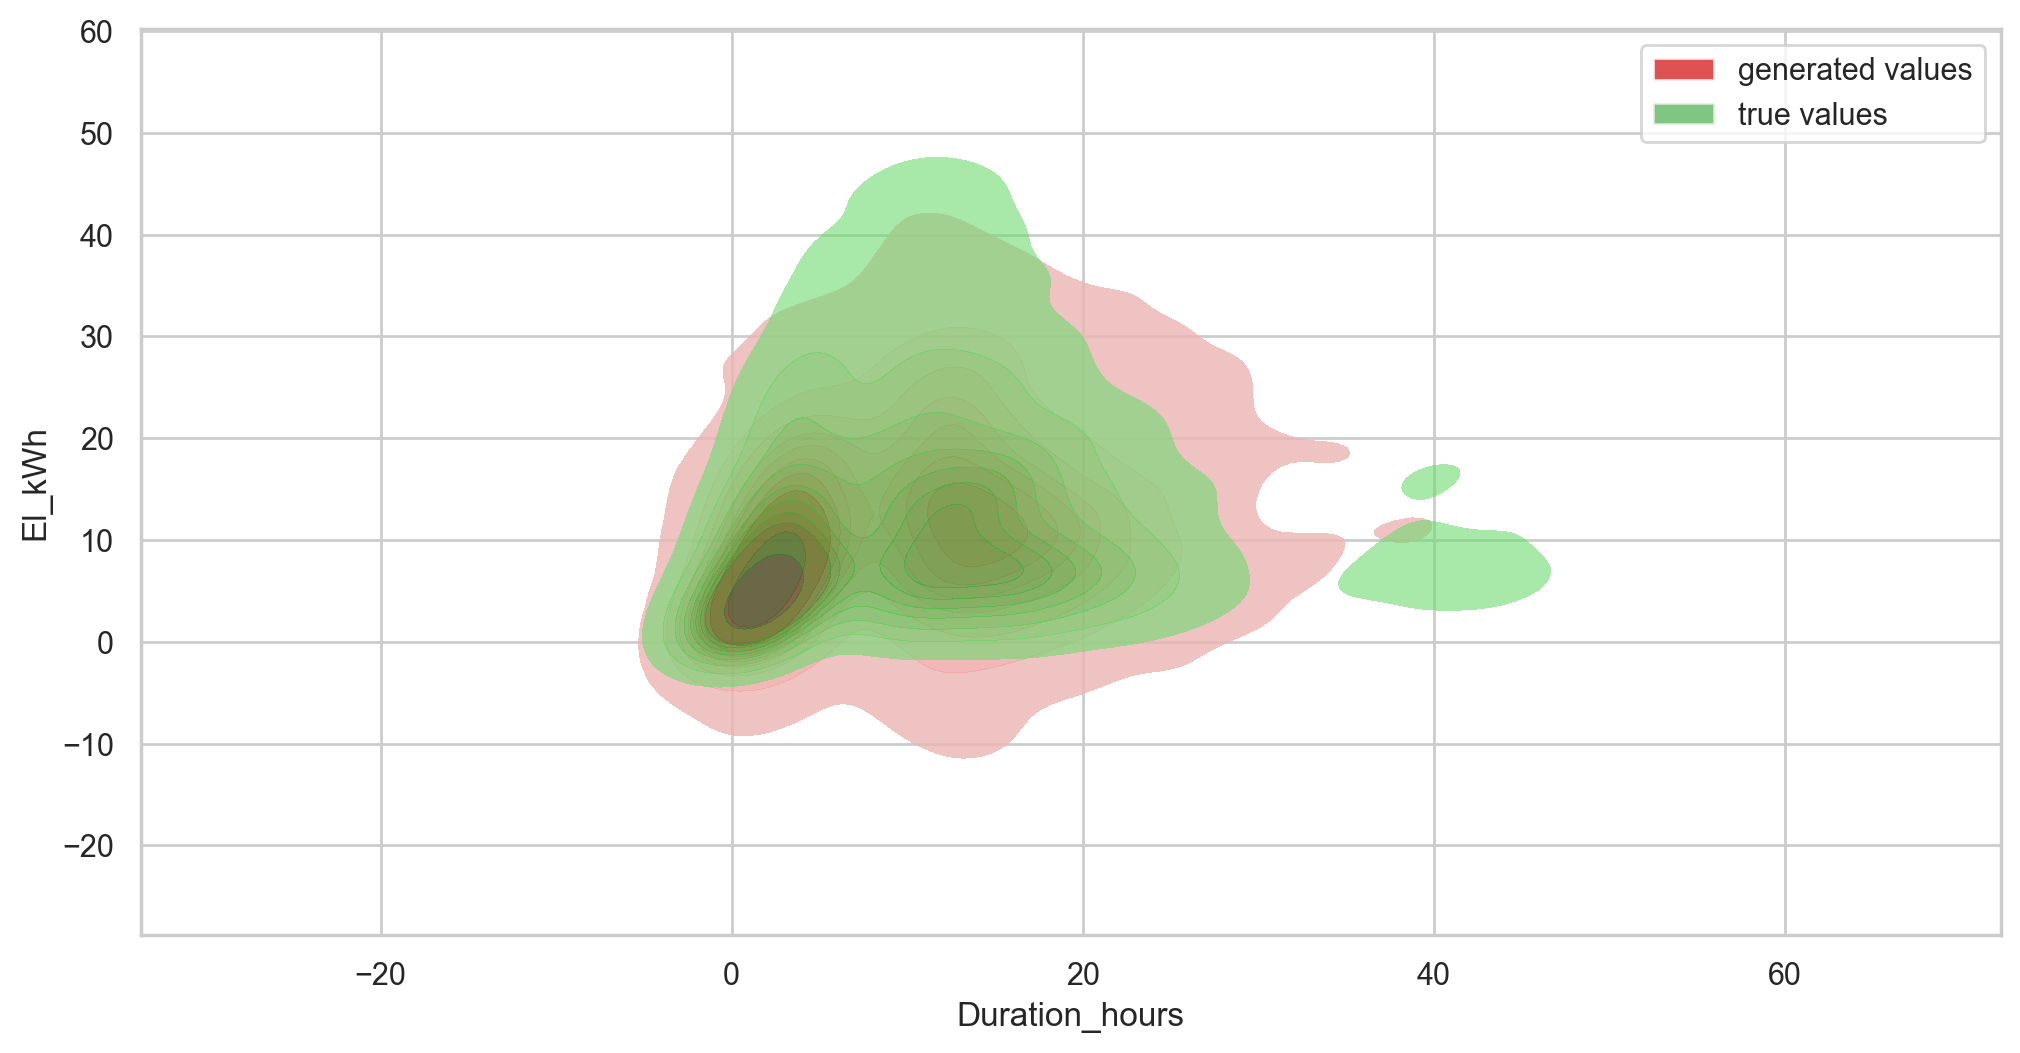

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
generated_kde = sns.kdeplot(
    data=density_generated_df,
    x="Duration_hours",
    y="El_kWh",
    shade=True,
    color="#d62728",
    alpha=0.8,
    ax=ax,
)
true_kde = sns.kdeplot(data=density_df, x="Duration_hours", y="El_kWh", shade=True, color="#2ca02c", alpha=0.6, ax=ax)
handles = [
    mpatches.Patch(facecolor="#d62728", alpha=0.8, label="generated values"),
    mpatches.Patch(facecolor="#2ca02c", alpha=0.6, label="true values"),
]
ax.legend(handles=handles);

## Conditional distribution $p(\text{Duration_hours}, \text{El_kWh} | \text{Start_plugin_hour})$

### True conditional samples

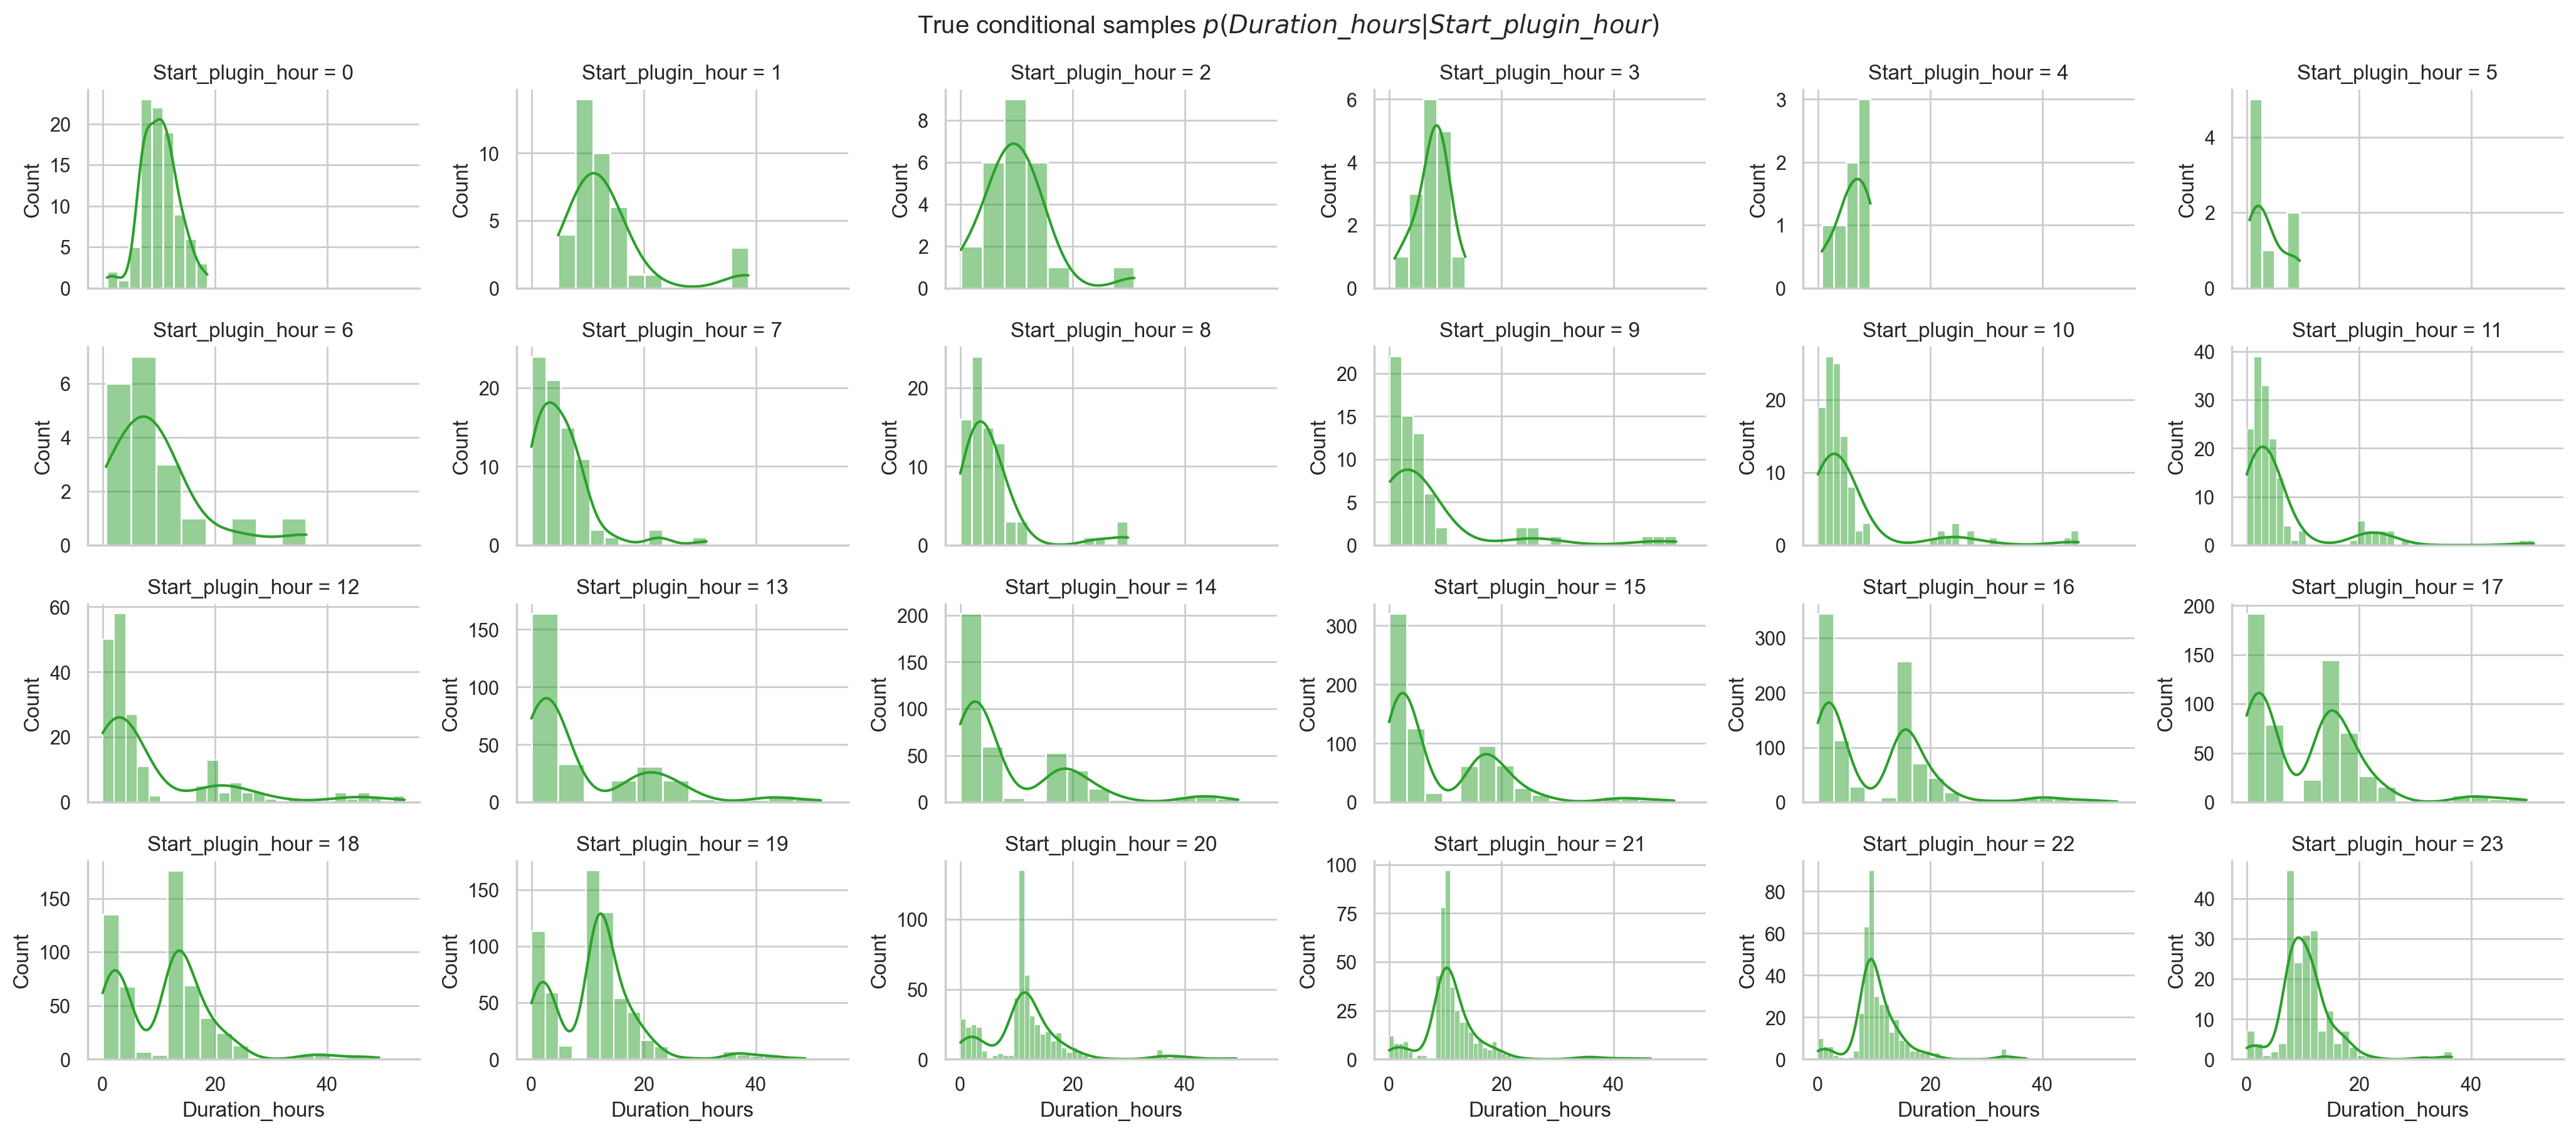

In [23]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "Duration_hours", kde=True, color="#2ca02c")
g.figure.suptitle(r"True conditional samples $p(Duration\_hours | Start\_plugin\_hour)$")
g.figure.tight_layout();

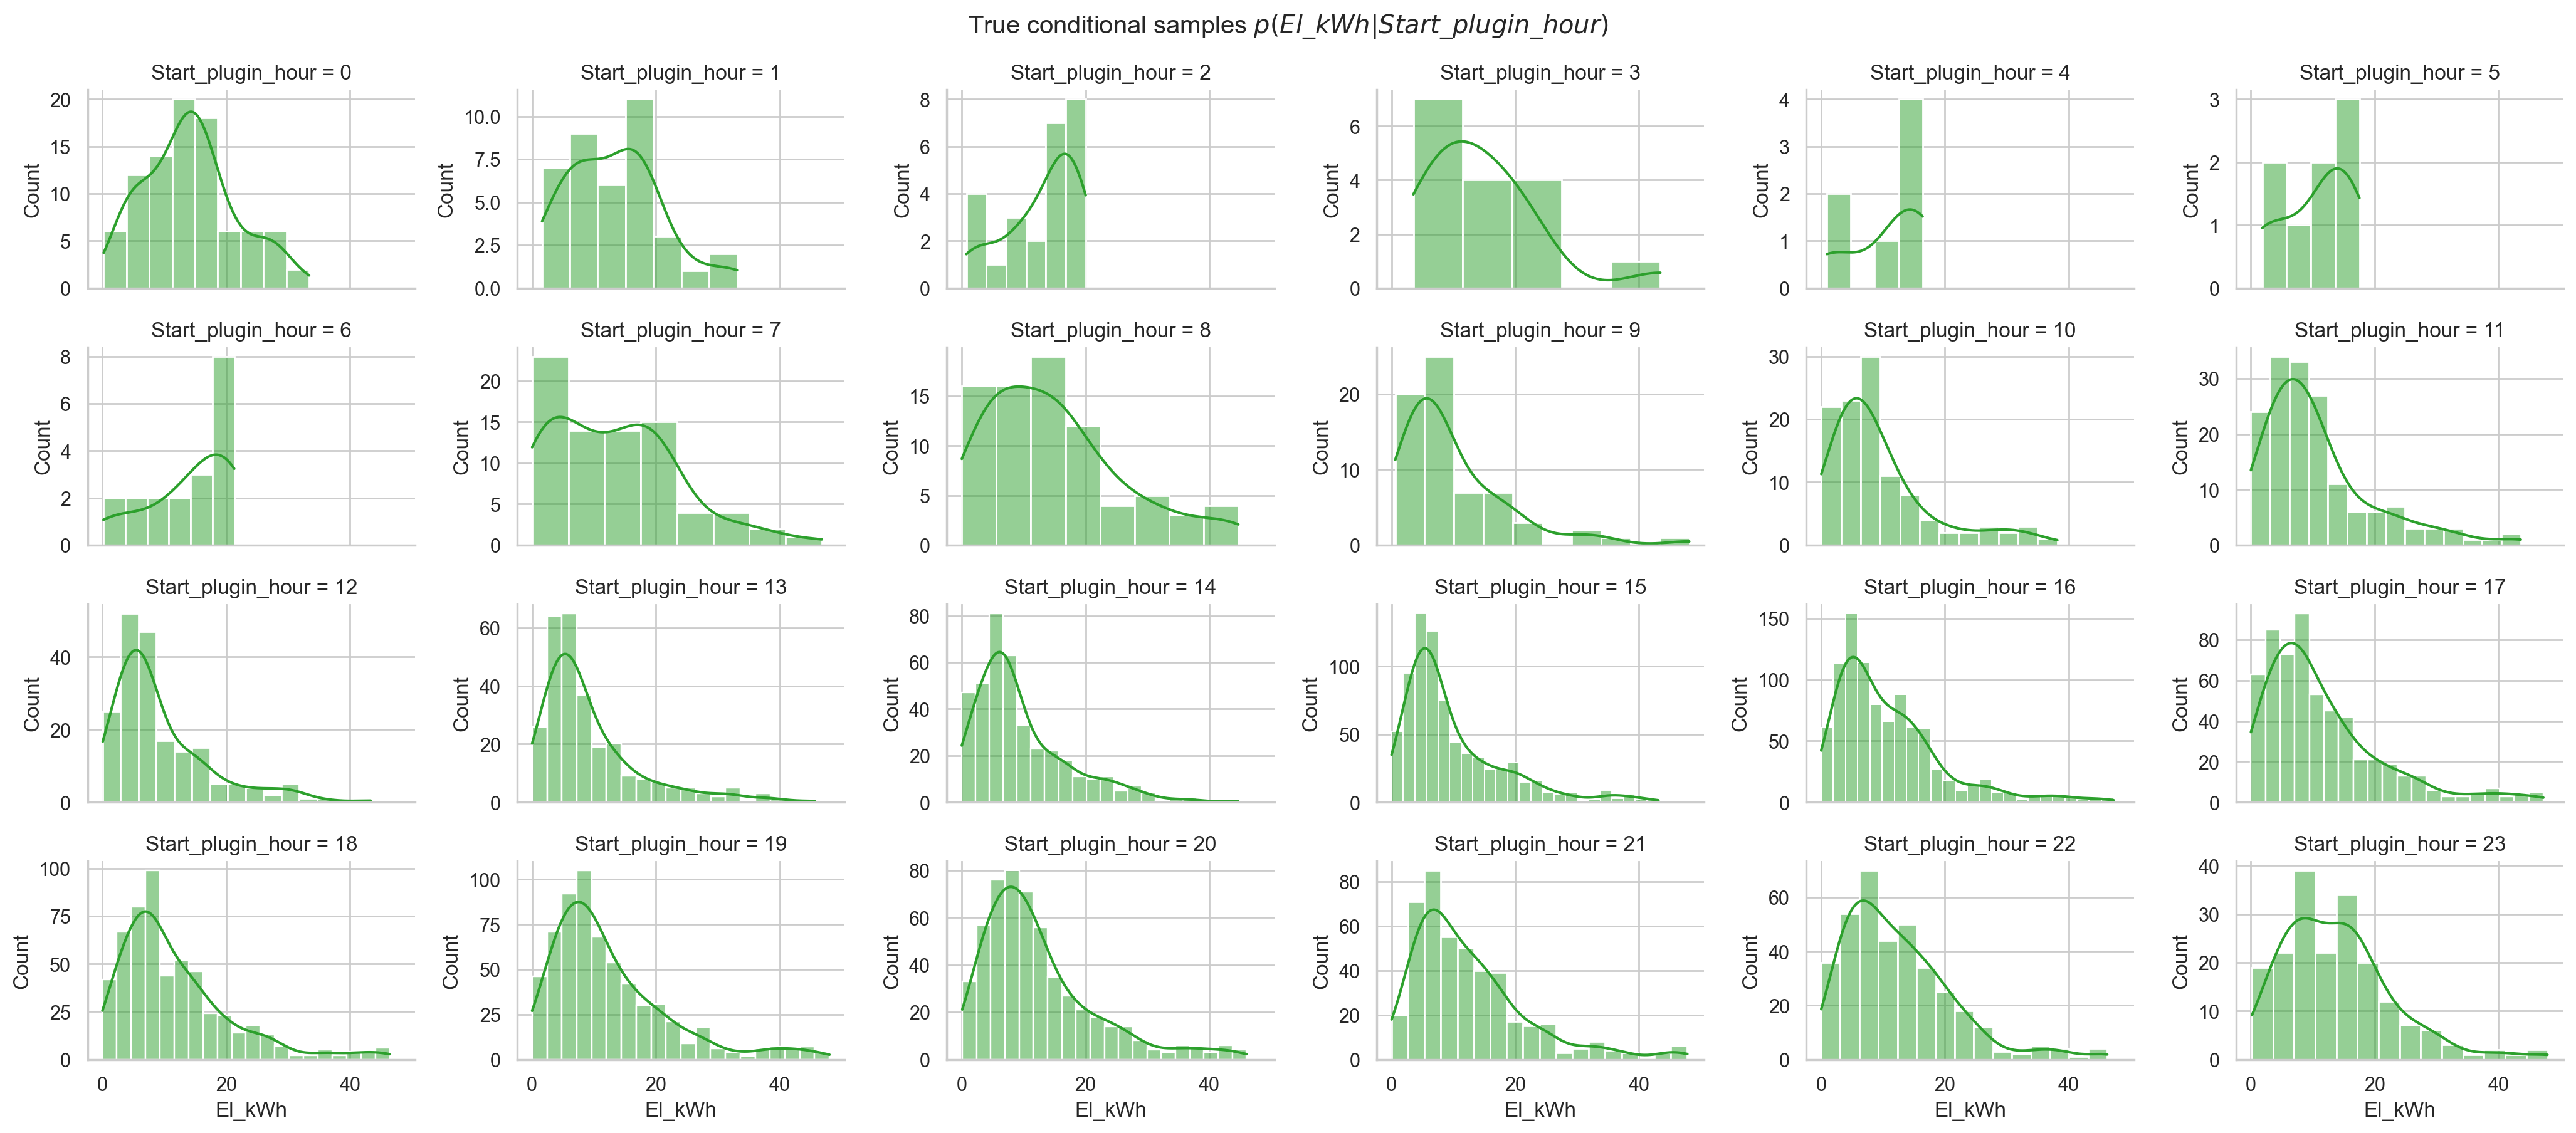

In [24]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.histplot, "El_kWh", kde=True, color="#2ca02c")
g.figure.suptitle(r"True conditional samples $p(El\_kWh | Start\_plugin\_hour)$")
g.figure.tight_layout();

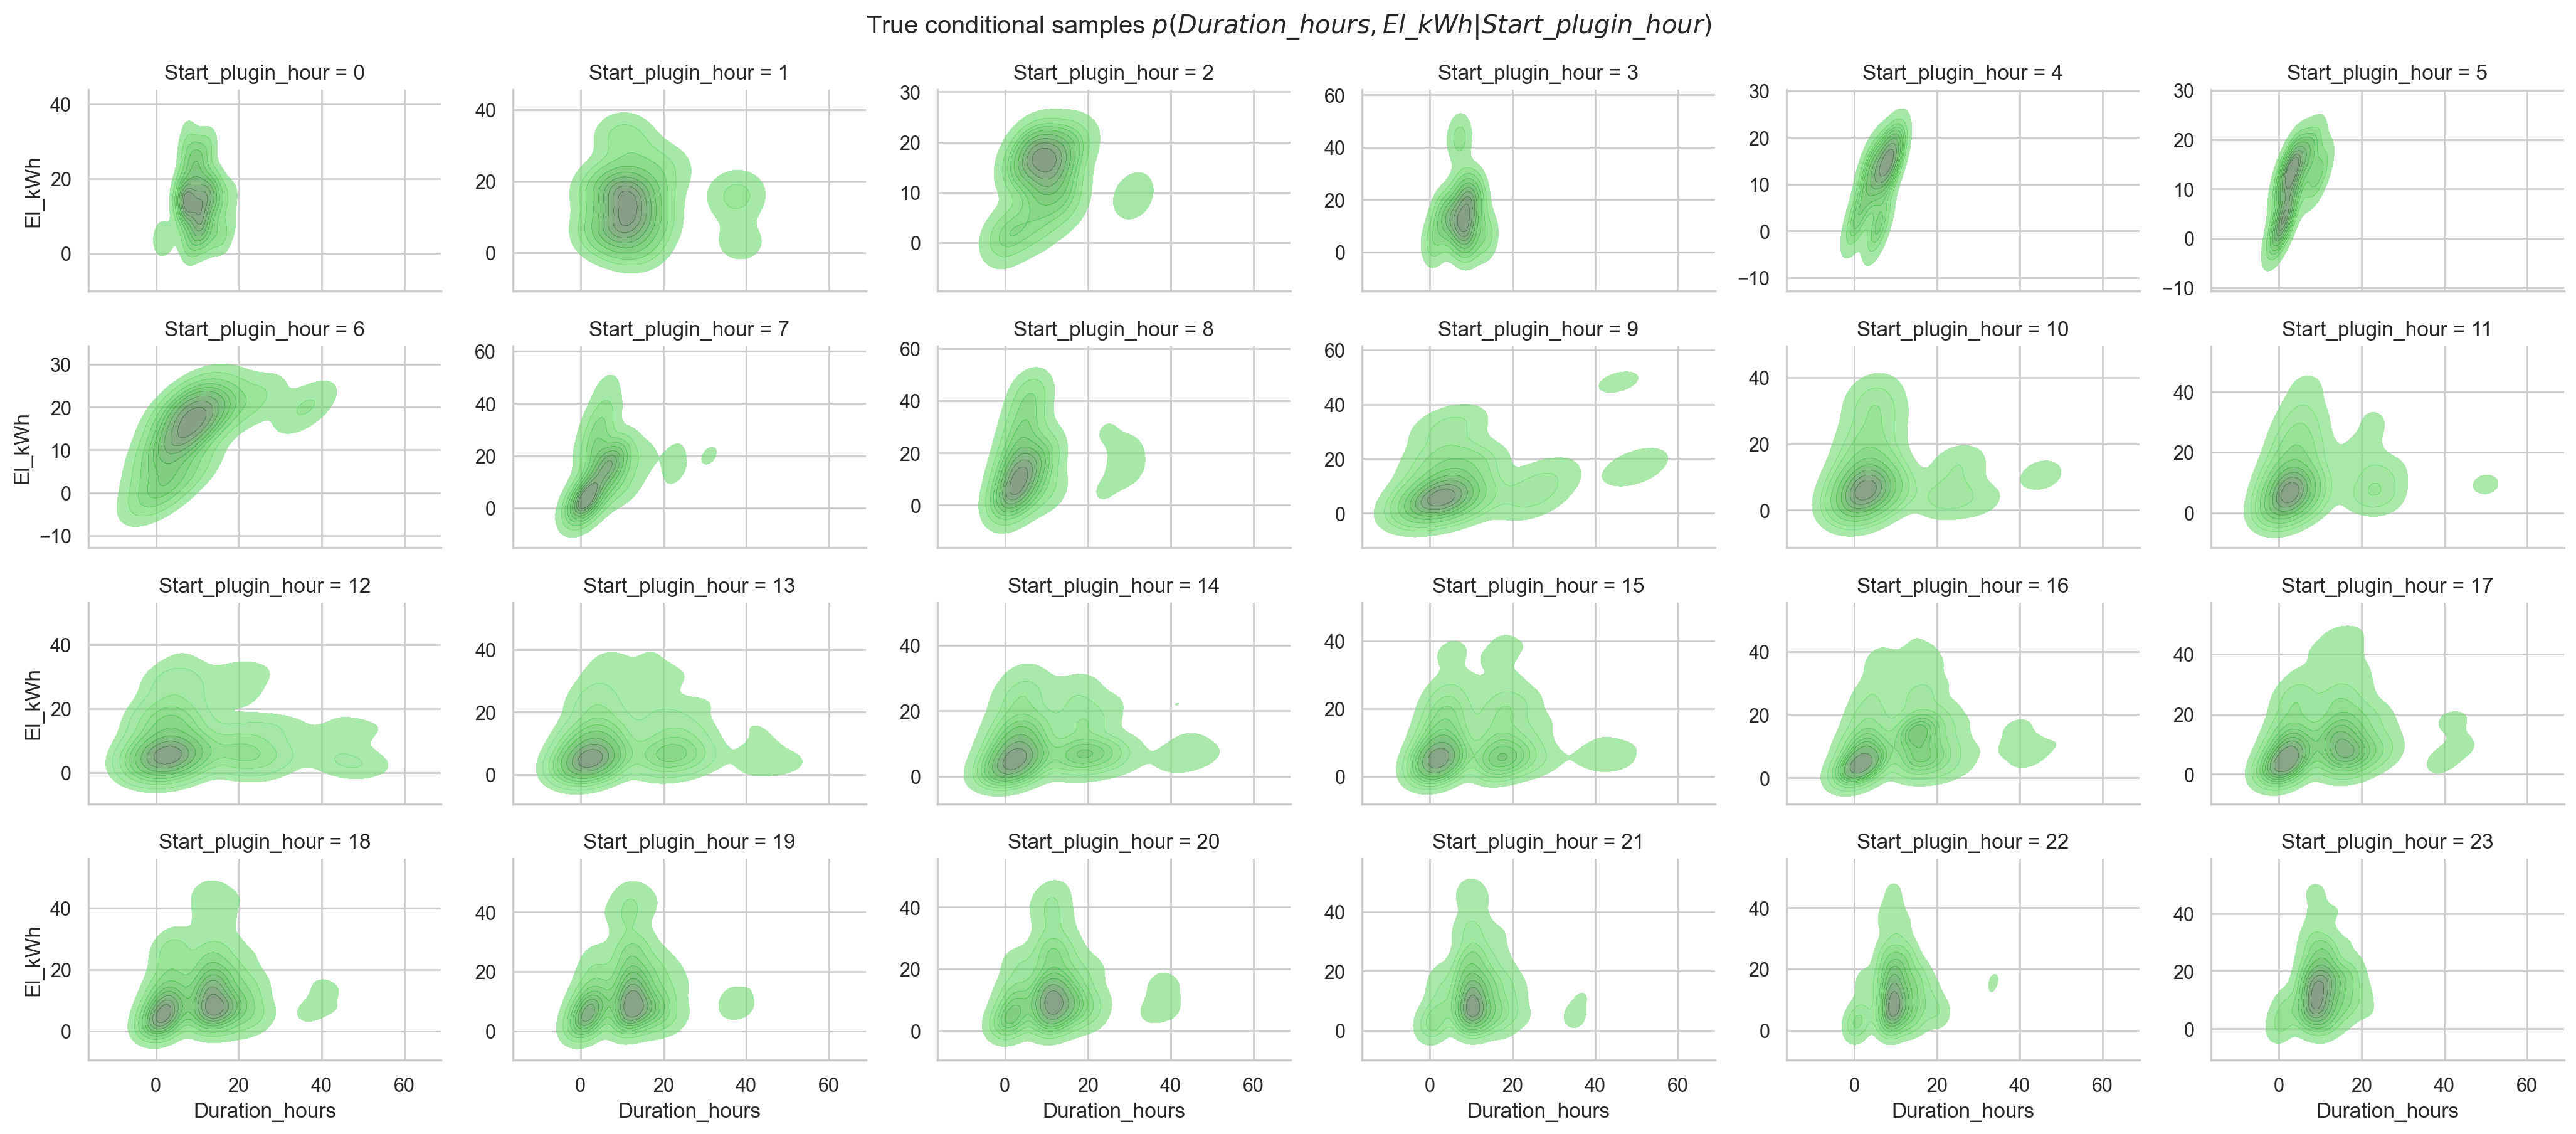

In [25]:
g = sns.FacetGrid(
    density_df,
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
)
g.map(sns.kdeplot, "Duration_hours", "El_kWh", shade=True, alpha=0.6, color="#2ca02c")
g.figure.suptitle(r"True conditional samples $p(Duration\_hours, El\_kWh | Start\_plugin\_hour)$")
g.figure.tight_layout();

### Estimated conditional distributions by GMM
Now, we want to calculate the conditional distribution $p(\text{Duration_hours}, \text{El_kWh} | \text{Start_plugin_hour})$ estimated by the GMM. To do that, we have to derive the conditional distributions for each GMM mixture component. Luckily, the conditional distribution for one set of variables, given all other variables of a joint multivariate normal distribition is a (multivariate) normal distribution with well defined moments.

The formula to derive the conditional distribution $p(X | Y) \sim \mathcal{N}$ for a joint multivariate normal distribution $p(X, Y) \sim \mathcal{MVN}$ is on Wikipedia: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions.

In [26]:
mvns = [MultivariateNormal(mean, cov) for mean, cov in zip(best_gmm.means_, best_gmm.covariances_)]
weights = np.array(best_gmm.weights_)

In [27]:
cond_gmm = ConditionalMvnMixture(mvns, weights)
cond_gmm.partition(2)

In [28]:
%%time
# TODO: Improve the sampling speed and run multiple experiments afterwards

rng = np.random.default_rng()
density_conditional_gen_df = pd.DataFrame()
for hour in range(24):
    len_true_data: int = len(density_df[density_df["Start_plugin_hour"] == hour])
    sample_data = np.zeros((len_true_data, 2), dtype=float)
    for i in range(len_true_data):
        # Sample conditional distribition component for Duration_hours and El_kWh by fixing Start_plugin_hour = hour
        mean, cov = cond_gmm.cond_dist(0, hour)
        sample = rng.multivariate_normal(mean, cov, 1).reshape(-1)
        # Sample again if sampled value is smaller or equal to zero
        while sample[0] <= 0 or sample[1] <= 0:
            sample = rng.multivariate_normal(mean, cov, 1).reshape(-1)
        sample_data[i] = sample
    density_conditional_gen_df = pd.concat(
        [
            density_conditional_gen_df,
            pd.DataFrame({"Duration_hours": sample_data[:, 0], "El_kWh": sample_data[:, 1], "Start_plugin_hour": hour}),
        ]
    )

CPU times: user 6.38 s, sys: 45 ms, total: 6.43 s
Wall time: 6.4 s


In [29]:
density_conditional_sample_df_vs_gen_df = pd.concat([density_df, density_conditional_gen_df], axis=0).reset_index(
    drop=True
)
density_conditional_sample_df_vs_gen_df.loc[: len(density_conditional_gen_df), "type"] = "true values"
density_conditional_sample_df_vs_gen_df.loc[len(density_conditional_gen_df) :, "type"] = "generated values"
density_conditional_sample_df_vs_gen_df["type"].value_counts()

true values         6544
generated values    6544
Name: type, dtype: int64

/Users/phipag/Library/Caches/pypoetry/virtualenvs/ev-simulation-model-2zYA4lj1-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


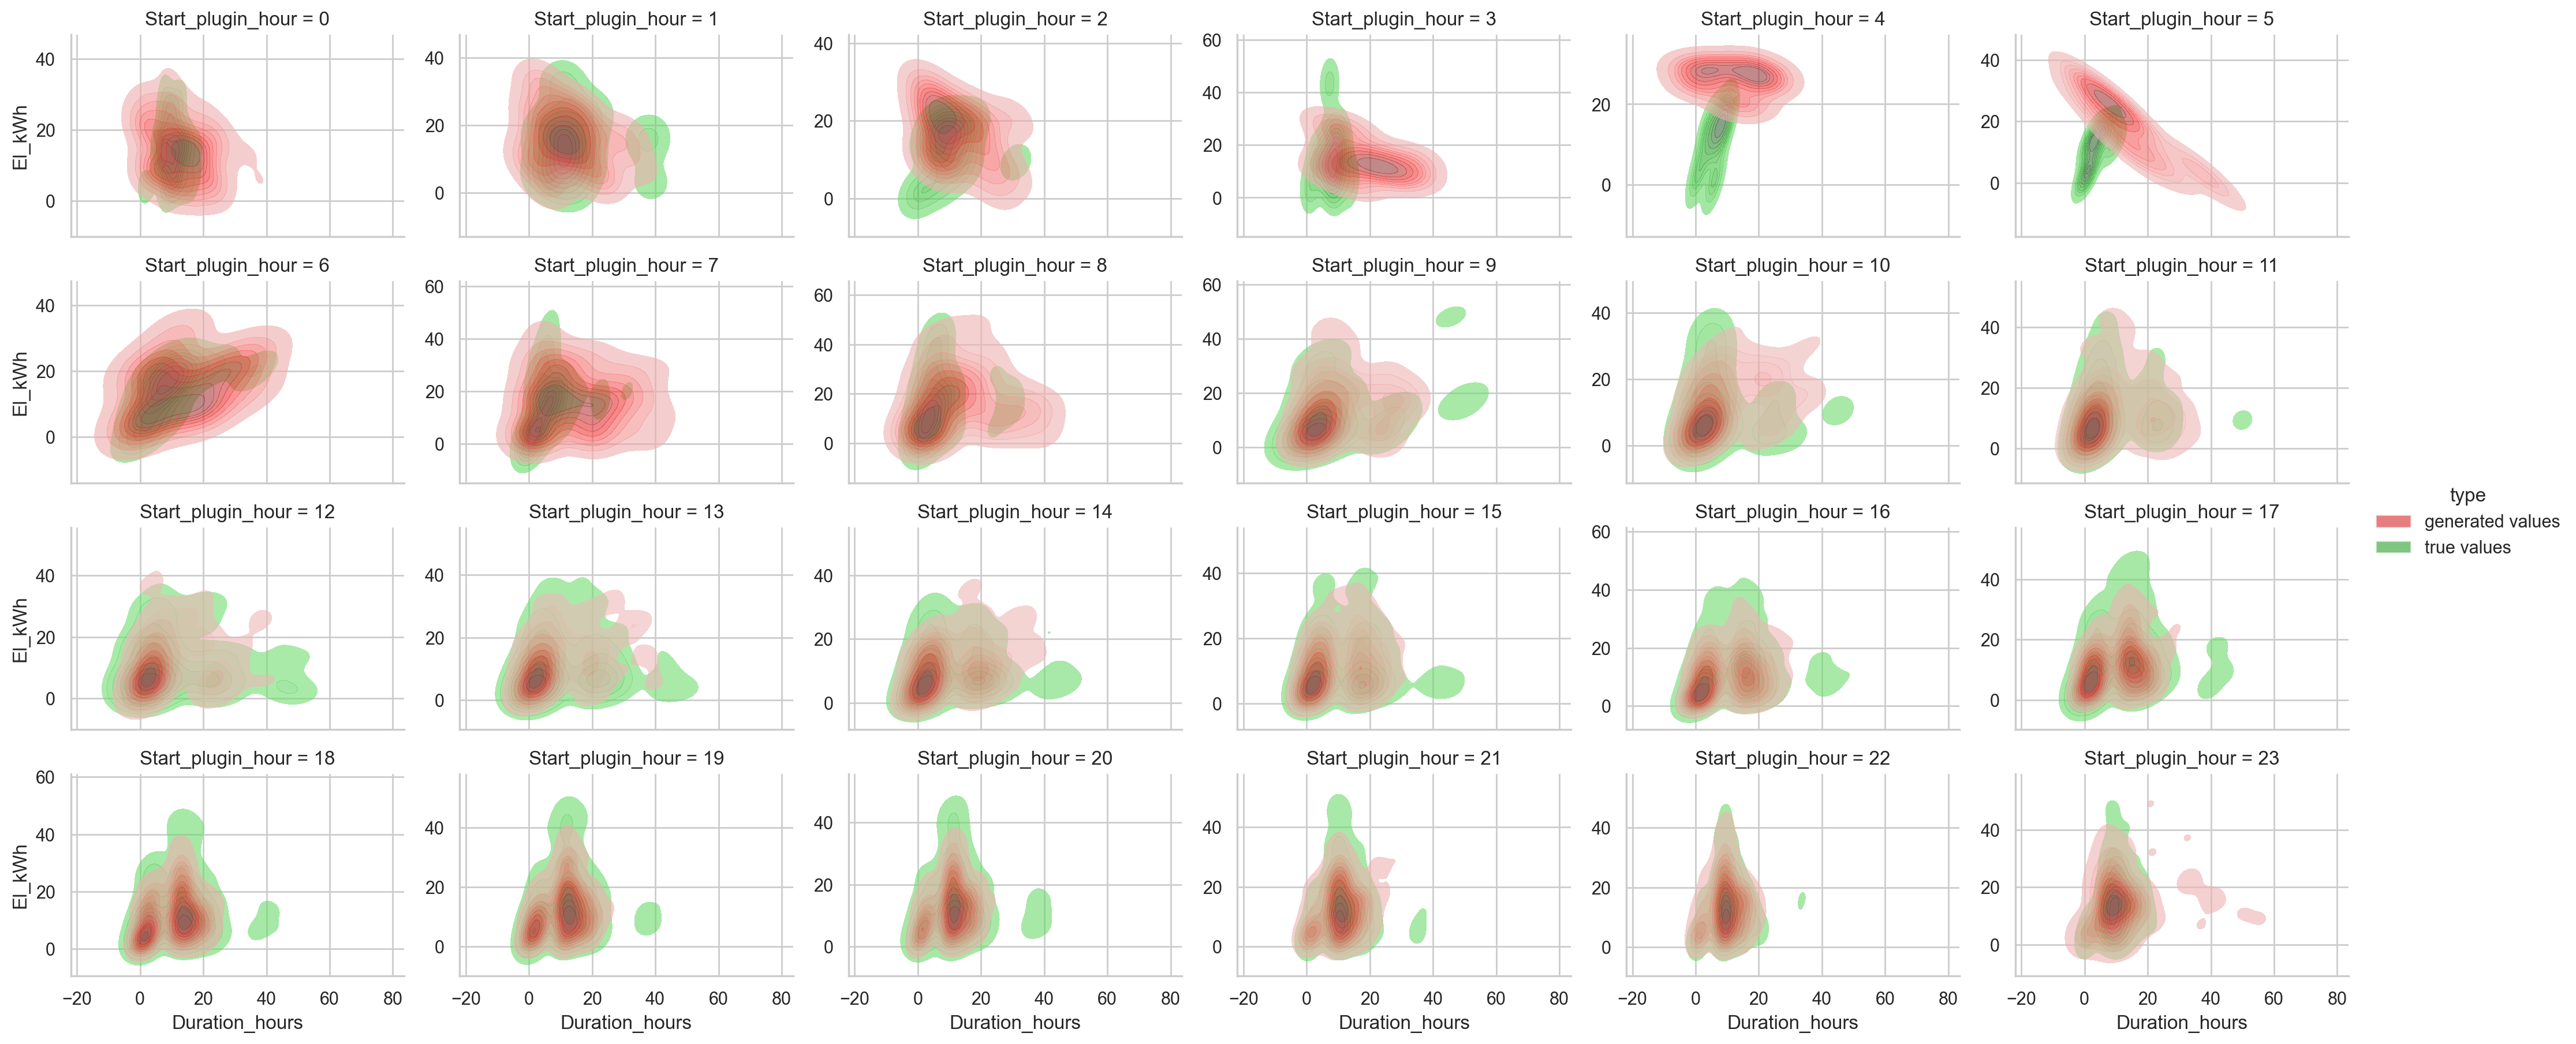

In [30]:
g = sns.FacetGrid(
    density_conditional_sample_df_vs_gen_df,
    hue="type",
    col="Start_plugin_hour",
    col_wrap=6,
    height=2.3,
    aspect=1.5,
    sharey=False,
    palette=["#2ca02c", "#d62728"],
)
g.map(sns.kdeplot, "Duration_hours", "El_kWh", shade=True, alpha=0.6, legend=True)
g.add_legend(
    handles=[
        mpatches.Patch(facecolor="#d62728", alpha=0.6, label="generated values"),
        mpatches.Patch(facecolor="#2ca02c", alpha=0.6, label="true values"),
    ]
);

## Marginal distribution $p(\text{Start_plugin_hour})$
This represents the probability that someone plugs-in their vehicle to an EV charger at the given hour. In a population model this can be multiplied by the size of the population of chargers.

**For example:** If we have 1000 EV chargers and the probability of charging is 0.2 at hour 12, it means that 200 new vehicles plug-in at 12 o'clock.

In [31]:
pop_size = 1000

In [32]:
rng = np.random.default_rng()
marg_mvns = [mvn.marg_dist(1) for mvn in mvns]
draws = np.hstack([rng.multivariate_normal(mvn[0], mvn[1], pop_size).astype(np.int32) for mvn in marg_mvns])

In [33]:
plugin_hour_sample_df = pd.DataFrame(draws, columns=[f"mvn{i}" for i in range(len(mvns))])
plugin_hour_sample_df

mvn0  mvn1  mvn2  mvn3  mvn4
0      21    18    13    16     9
1      19    17    15    10    17
2      16    20    10    12    23
3      17    16    13    17    14
4      19    17    23    15     9
..    ...   ...   ...   ...   ...
995    17    17    19     7    19
996    15    19    12    12    -2
997    16    16    22    11    12
998    15    21    15    13    13
999    18    22    17    16    17

[1000 rows x 5 columns]

In [34]:
samples_per_mvn = rng.multinomial(pop_size, weights)
samples_per_mvn

array([254, 230, 145, 254, 117])

In [35]:
weighted_samples = np.hstack(
    [plugin_hour_sample_df[col].sample(num) for col, num in zip(plugin_hour_sample_df.columns, samples_per_mvn)]
)
# Simply omit values outside of the interval [0, 23] because these are no valid hours
weighted_samples = weighted_samples[(weighted_samples >= 0) & (weighted_samples <= 23)]

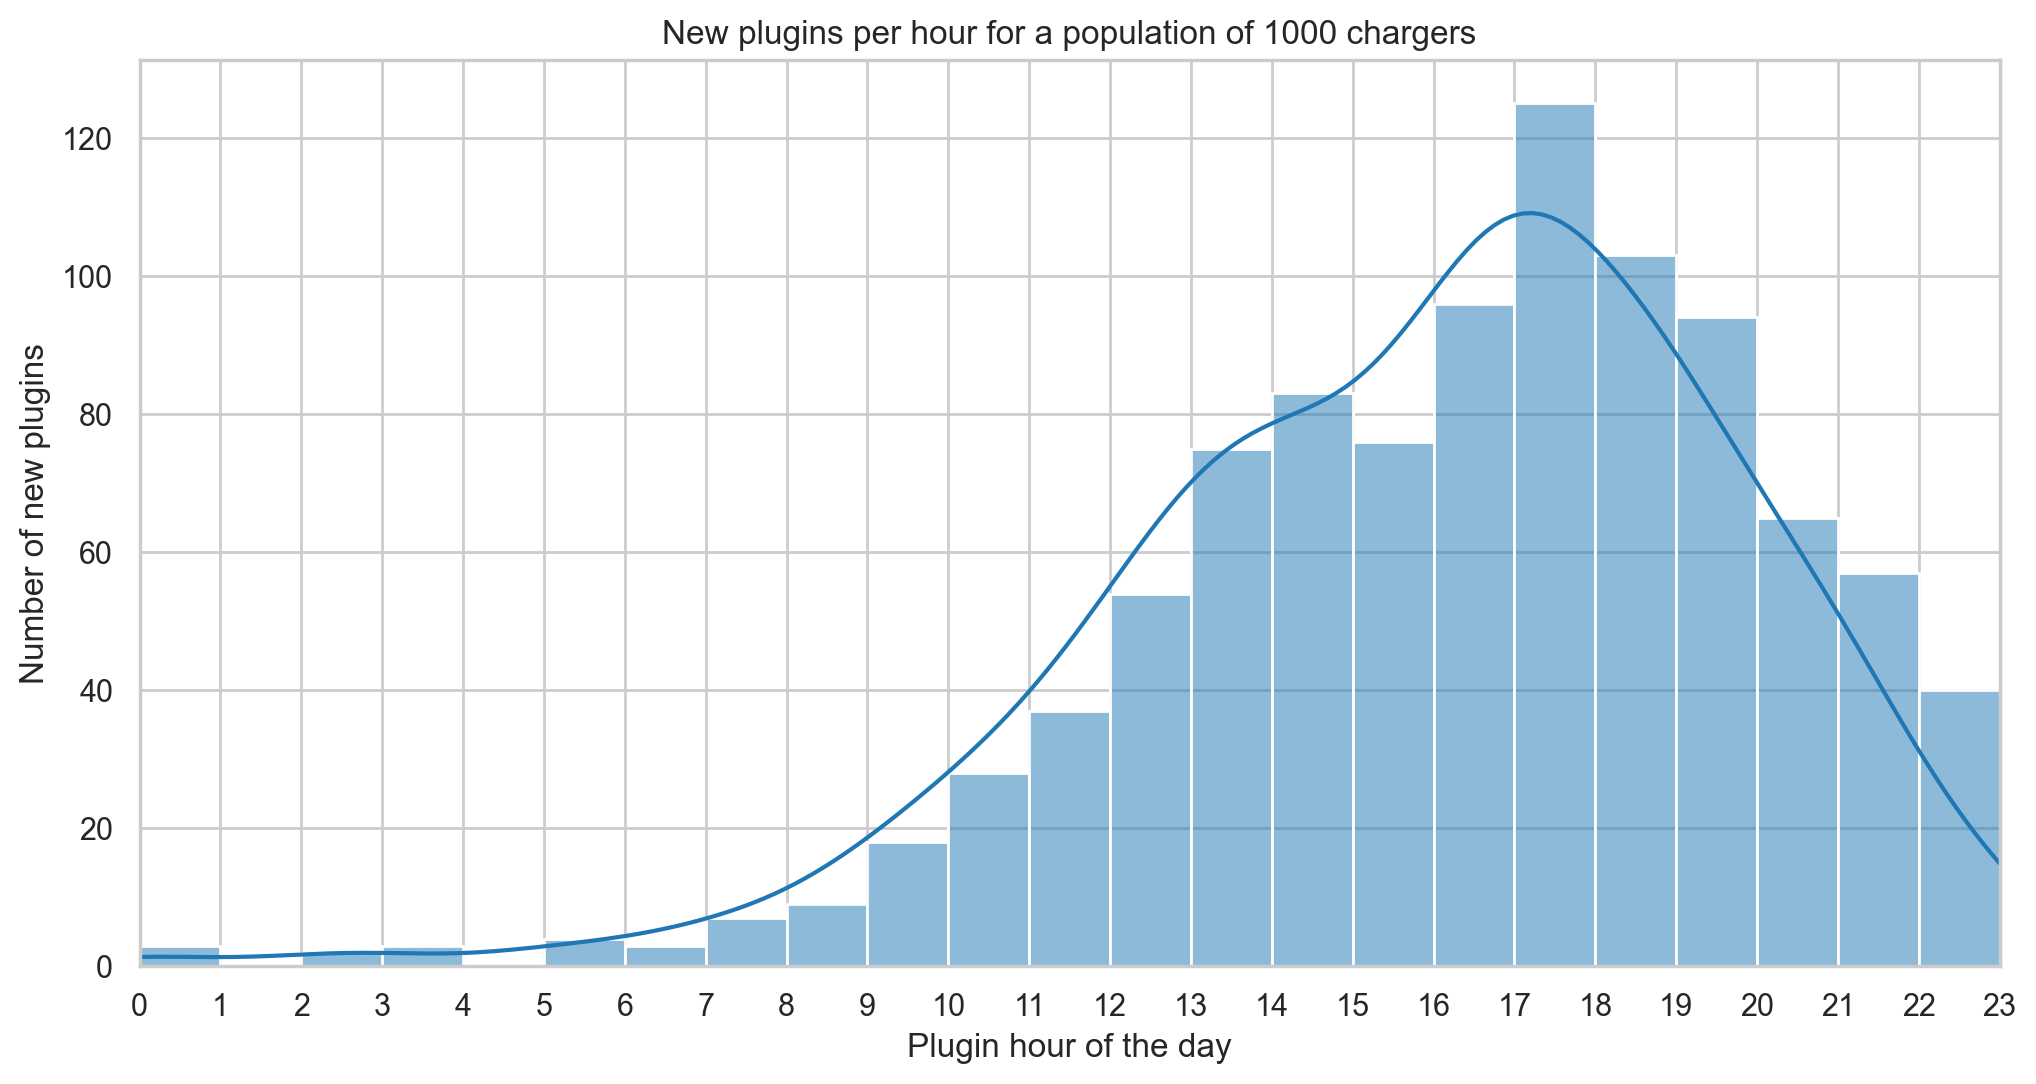

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(weighted_samples, kde=True, bins=24, binwidth=1, ax=ax)
ax.set_xticks(range(24))
ax.set_xmargin(0)
ax.set_xlabel("Plugin hour of the day")
ax.set_ylabel("Number of new plugins")
ax.set_title(f"New plugins per hour for a population of {pop_size} chargers");

## Export conditional distributions to XML file

In [37]:
exporter = ConditionalMvnMixtureExporter(
    root_name="residentialEv",
    cond_mvn_mixture=cond_gmm,
    conditionals=[hod for hod in range(24)],
    conditional_names=[f"hod{hod}" for hod in range(24)],
    cond_ind=0,
    marg_ind=1,
    marg_name="pluginProbability",
)
exporter.export("residential_ev.xml")